# Portfolio assignment 4 - Representational Similarity Analysis (RSA)
Vlada Caraman

#### Activate environment 

In [2]:
import os
path='/work/student_folders/vlada_folder/notebooks_fMRI' 
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


#### Import packages 

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<02:39, 966B/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<03:50, 2.21kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<03:38, 2.22kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<04:29, 3.42kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<07:21, 13.9kB/s]


Autosaving every 5 seconds


#### Load data

In [43]:
# Load the data for subject "KO"
subj_initials = 'SN'
ns_data_dir = os.path.join('/work/notebooks_fMRI/data', 'NinetySix')

all_subj_initials = {'BE', 'KO', 'SN', 'TI'}
rois_to_remove = ['lLO', 'rLO']
#FFA: Fusiform Face Area. PPA: Parahippocampal Place Area 
rois_to_keep = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

def load_data_for_a_subj(subj_initials):
    assert subj_initials in all_subj_initials
    images = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_images.mat' % (subj_initials))
    )['images']  
    data = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_roi_data.mat' % (subj_initials))
    ) 
    
    # Unpack metadata 
    roi_data_all = data['roi_data']
    roi_names = data['roinames']
    labels = np.array(data['labels'])
    categoryNames = data['categoryNames']

    # Re-format metadata labels and ROIs
    n_categories = categoryNames.shape[1]
    n_rois = roi_names.shape[1]
    categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range(n_rois)]
    labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}

    # Remove r/lLO
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in rois_to_keep: 
            roi_data.append(roi_data_all[0, r])
    roi_names = rois_to_keep
    n_rois = len(rois_to_keep)
    return images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict


data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

#### Inspect and visualize data

In [44]:
# Inspecting data 
print('ROI names:',roi_names)
print('Stimulus categories:', categories)
print(type(labels))
print('Trial labels:', labels)
print('Region of interest matrix sizes:')
for roi in roi_data:
    print (roi.shape)


ROI names: ['lFFA', 'rFFA', 'lPPA', 'rPPA']
Stimulus categories: ['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
<class 'numpy.ndarray'>
Trial labels: [2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Region of interest matrix sizes:
(96, 37)
(96, 145)
(96, 135)
(96, 112)


Text(0, 0.5, 'Stimulus category')

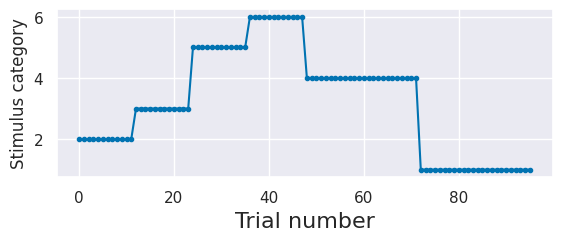

In [45]:
# Plotting stimulus categories
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Trial number', fontsize=16)
plt.ylabel('Stimulus category', fontsize=12)

#### Plot the lPPA data

In [46]:
# Looking at the ROIs
print('ROI names: ', roi_names)

ROI names:  ['lFFA', 'rFFA', 'lPPA', 'rPPA']


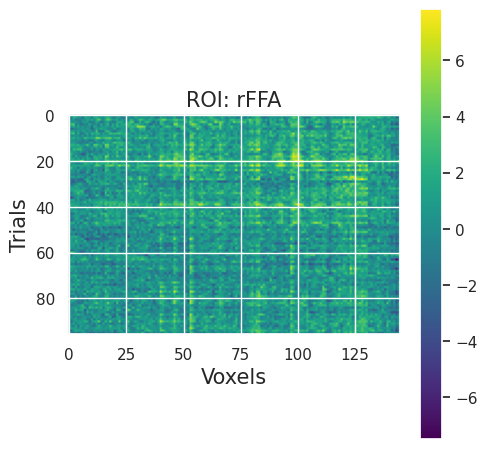

In [47]:
# Choose your ROI here (rFFA=1)!
roi_id = 1
# Create a data matrix R
R=roi_data[roi_id]
#Plot it
fig, axis = plt.subplots(1,1, figsize=(5, 5))
fig.tight_layout()
plt.imshow(R,cmap='viridis')
axis.set_title("ROI: rFFA", fontsize=15)
axis.set_xlabel("Voxels", fontsize=15)
axis.set_ylabel("Trials", fontsize=15)
plt.colorbar()

#### Create similarity matrix 

Text(0, 0.5, 'trial number')

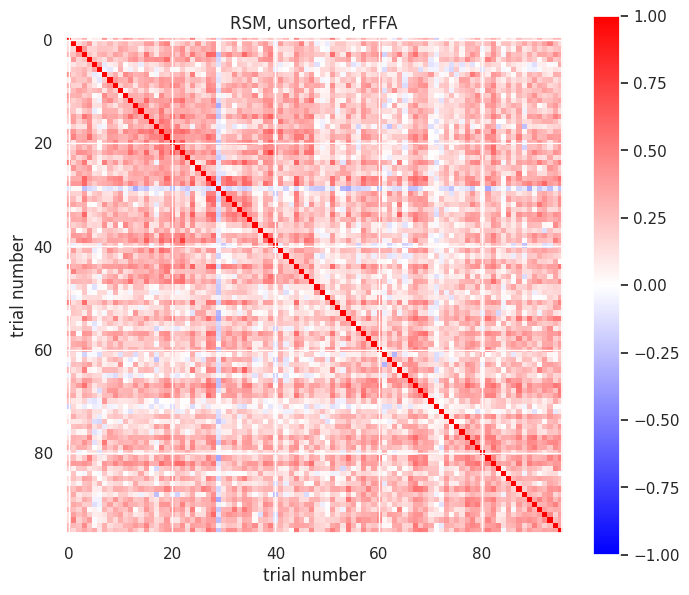

In [48]:
# Choosing the ROI here!
roi_id = 1

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    np.corrcoef(roi_data[roi_id]), 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (roi_names[roi_id])) 
ax.set_xlabel('trial number')
ax.set_ylabel('trial number')

#### Sort data

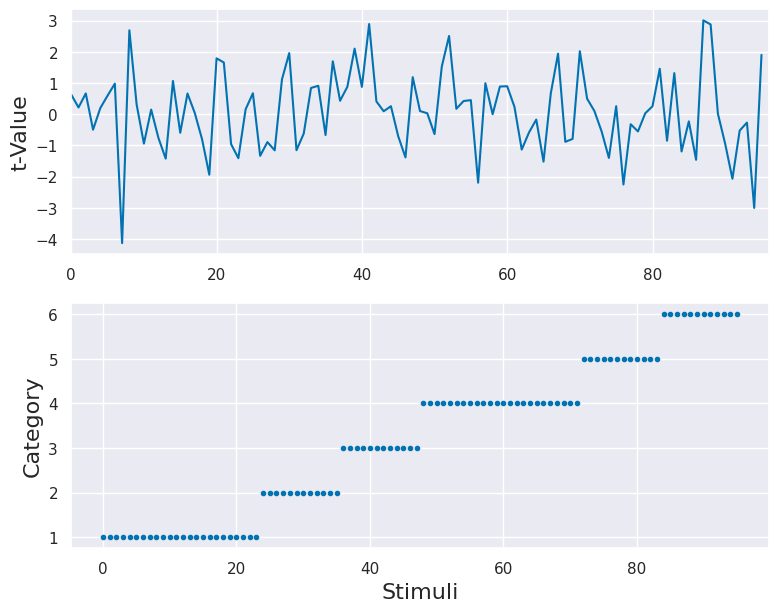

In [49]:
# Adding the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
sort_ids = labels.argsort()
rffa_sorted = roi_data[1][sort_ids, :]

plt.figure(figsize=(9,7))

# Plot the effects from one voxel with the new sorted results
plt.subplot(2,1,1)
plt.plot(rffa_sorted[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(labels[sort_ids],'.')
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

#### Reorder data in meaningful way

In [50]:
# Adding the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
new_order=('human face', 'human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate')

# Making a loop to make a vector of new labels
category_vec=[]
labels2=[]
for nn in range(len(labels[:92,])):
    #Making a vector with category names, rather than numeric labels
    category_vec.append(categories[int(labels[nn]-1)])
    
    # Comparing current category to new order, to make a vector of labels according the the new order
    for nnn in range(len(new_order)):
        if category_vec[nn]==new_order[nnn]:
            labels2.append(nnn)

##Inspect outcome
#print(category_vec)
#print(len(labels2))

#Make a new sorting index to use for plotting
labels2=np.array(labels2)
sort_ids2 = labels2.argsort()


#### Plot the representational similarity matrix (RSM)

Text(0.5, 1.0, 'RSM digitized rFFA')

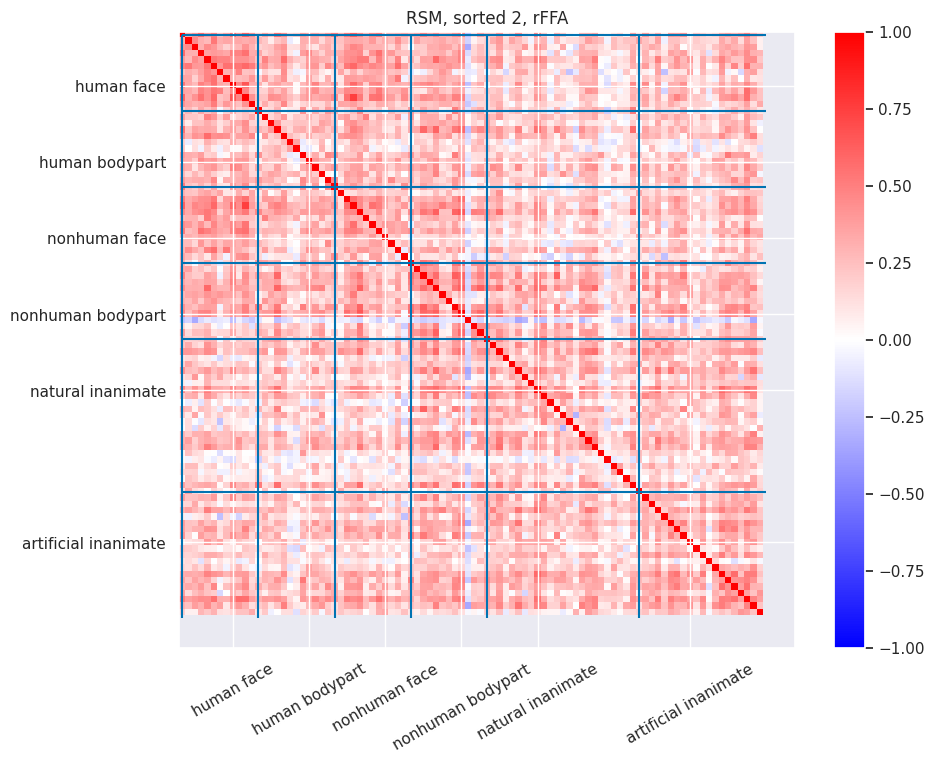

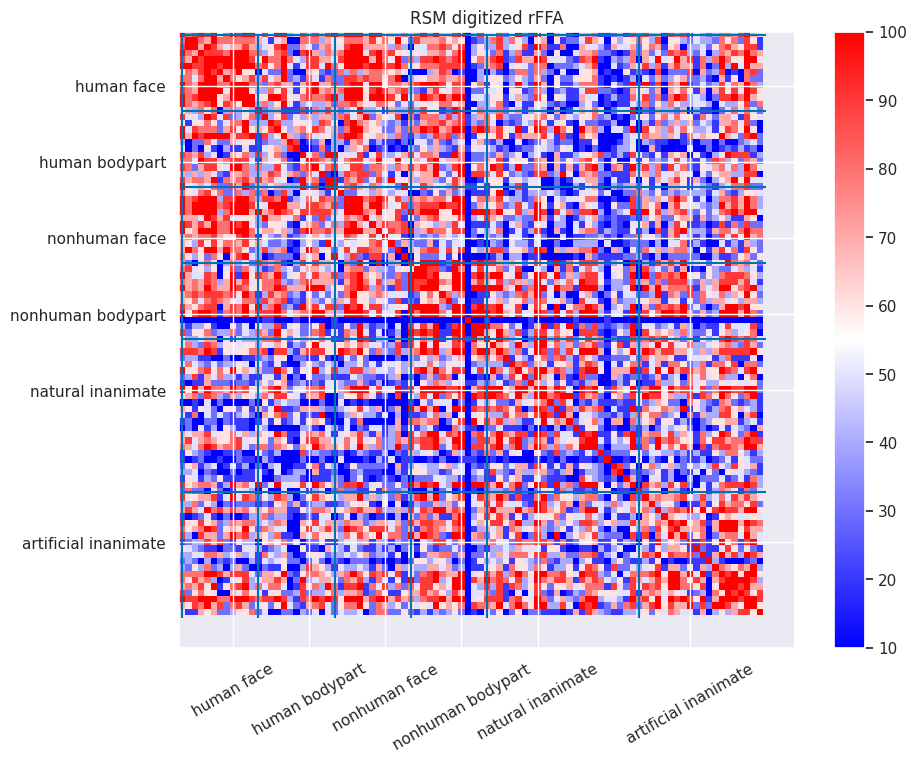

In [51]:
# Choosing the ROI here! 
roi_id = 1

# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rsm2 = np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rsm2, 
    cmap='bwr', 
    vmin=-1,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM, sorted 2, %s' % roi_names[roi_id])

# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rsm2), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RSM digitized %s' % roi_names[roi_id])

#### Representational dissimilarity

Text(0.5, 1.0, 'RDM, sorted 2, rFFA')

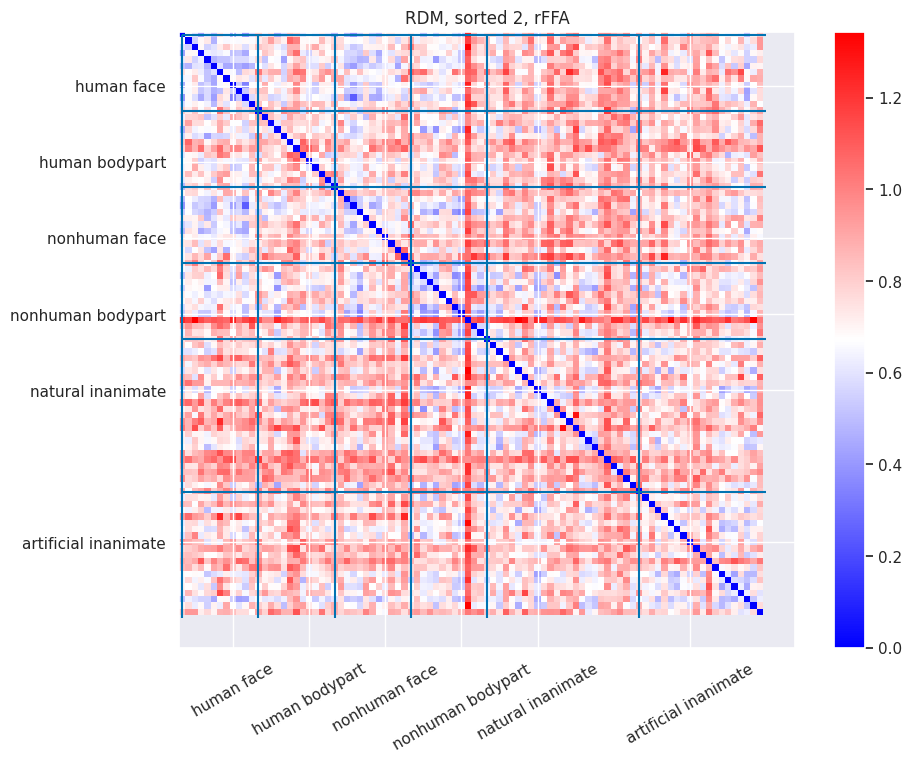

In [52]:
# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rdm = 1-np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rdm, 
    cmap='bwr', 
    
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RDM, sorted 2, %s' % roi_names[roi_id])

Text(0.5, 1.0, 'RDM digitized rFFA')

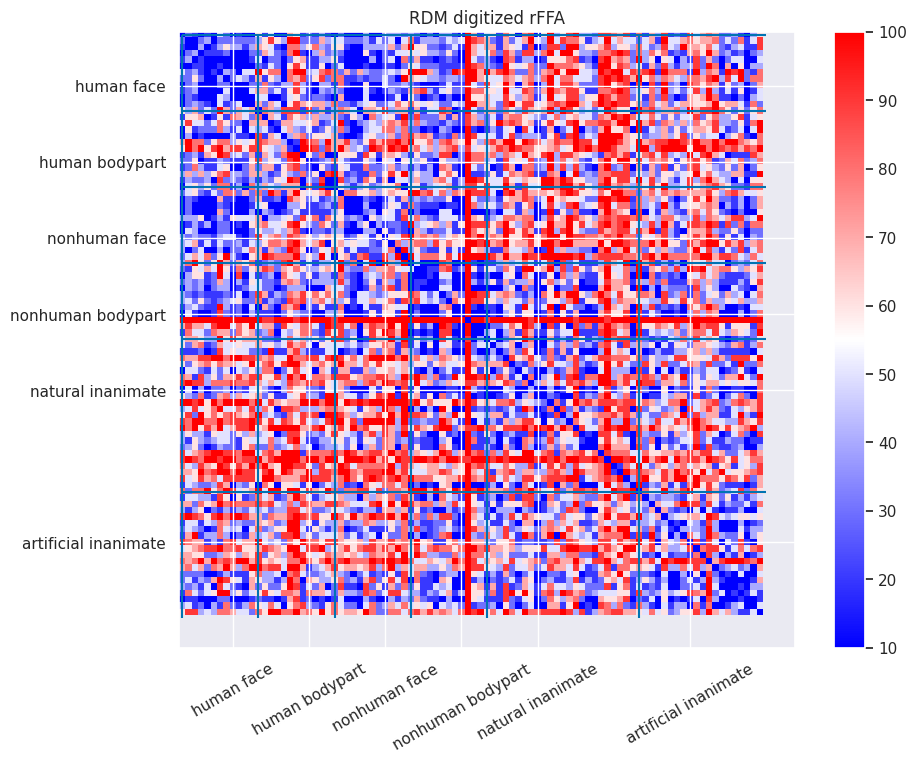

In [53]:
#Pearson digitized
# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rdm = 1-np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot the digitized RDM
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    digitize_rdm(rdm), 
    cmap='bwr', 
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RDM digitized %s' % roi_names[roi_id])



Text(0.5, 1.0, 'RDM (cosine distance), sorted 2, rFFA')

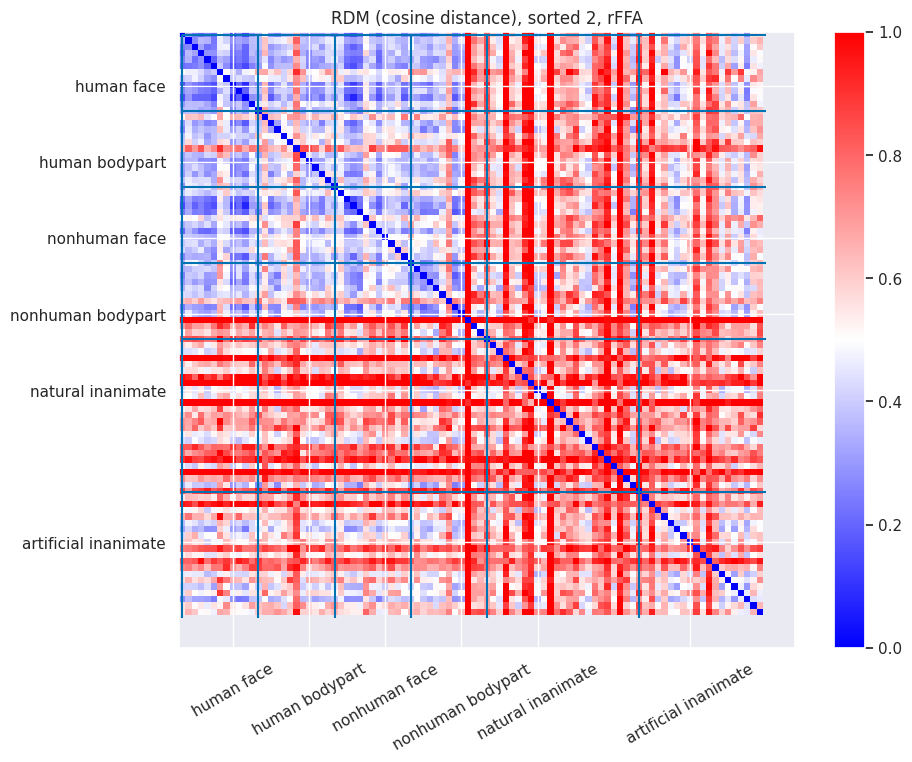

In [55]:
from sklearn.metrics import pairwise_distances

# Calculate the RDM
rdm_cos = pairwise_distances(R, metric='cosine')
#rdm_euc = pairwise_distances(R, metric='euclidian')

# Plot 
f, ax = plt.subplots(1,1, figsize=(10, 8))
plt.imshow(
    rdm_cos, 
    cmap='bwr', 
    vmin=0,
    vmax=1,
)
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges,0,92)
ax.hlines(edges,0,92)
ax.set_title('RDM (cosine distance), sorted 2, %s' % roi_names[roi_id])



#### Model RDM

In [56]:
# Grouping only rFFA-related stimulus categories
labels_an=1*(labels2<=3)
labels_hum=1*(labels2<=1)
labels_hum_face=1*(labels2==0)# + 1*(labels2==2)


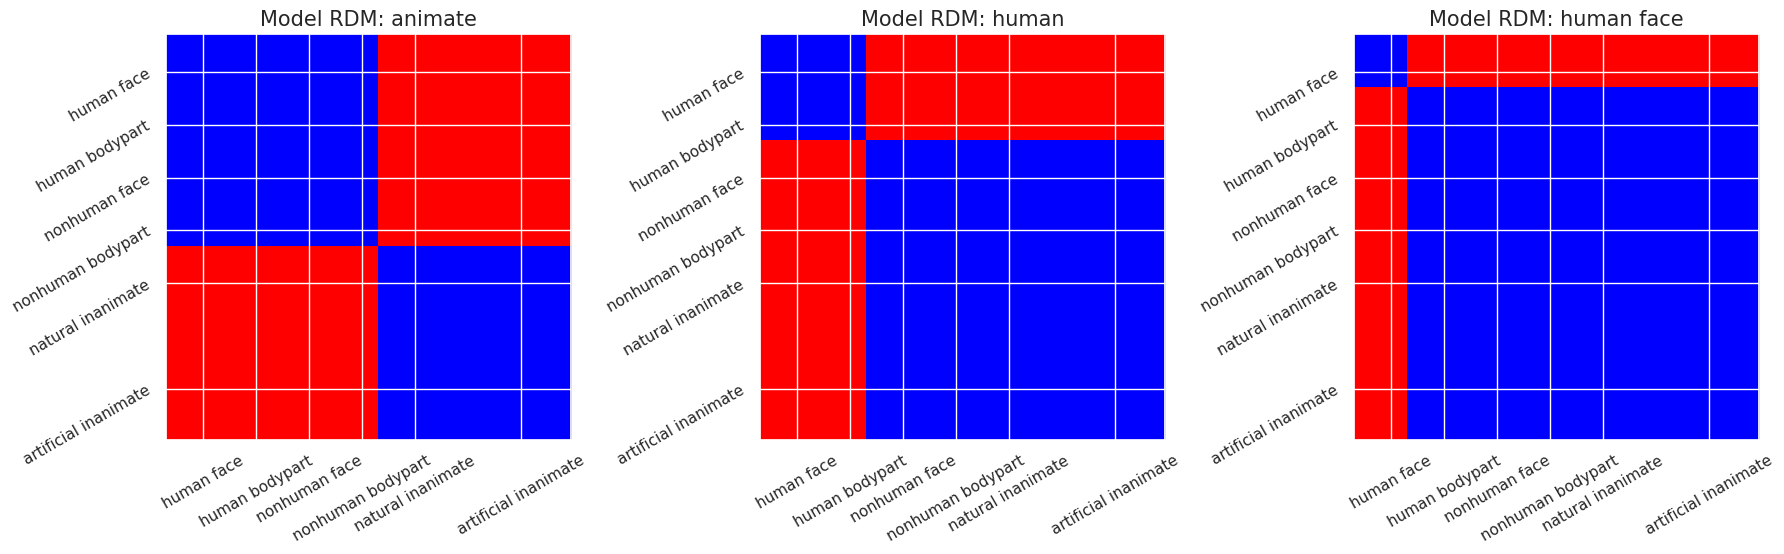

In [57]:
# Note the np.newaxis, which is needed because pairwise_distances
# assumes that the input is 2D

rdm_an = pairwise_distances(labels_an[sort_ids2, np.newaxis], metric='matching')
#rdm_an = pairwise_distances(hest, metric='manhattan')
rdm_hum = pairwise_distances(labels_hum[sort_ids2, np.newaxis], metric='manhattan')
rdm_hum_face = pairwise_distances(labels_hum_face[sort_ids2, np.newaxis], metric='manhattan')

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an,cmap='bwr')
axes[0].set_title("Model RDM: animate", fontsize=15)
axes[1].imshow(rdm_hum,cmap='bwr')
axes[1].set_title("Model RDM: human", fontsize=15)
axes[2].imshow(rdm_hum_face,cmap='bwr')
axes[2].set_title("Model RDM: human face", fontsize=15)
for i in range(3):
    axes[i].set_xticks(list(np.array(edges)+8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges)+8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

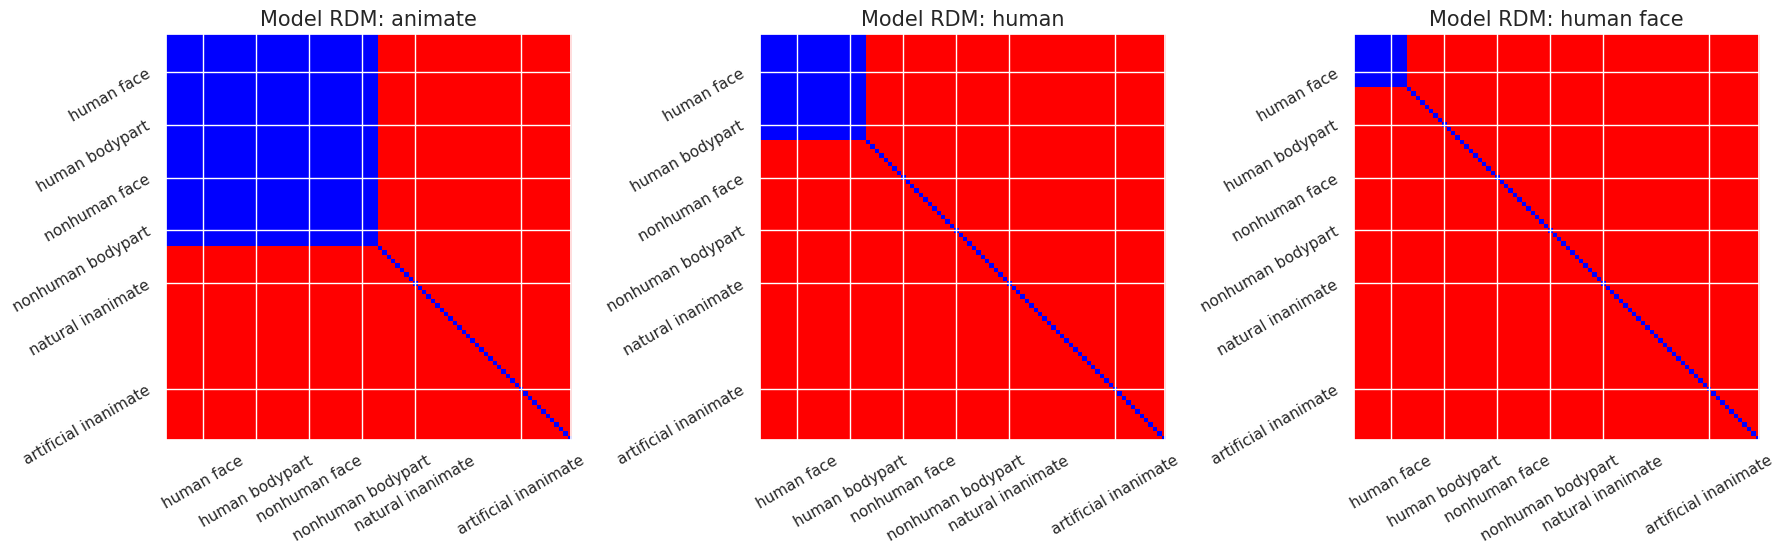

In [38]:

# Here is some ugly code to make alternative models
x1=np.tile(labels_an[sort_ids2],(sum(labels_an),1))
x2=np.zeros((len(labels_an)-sum(labels_an),len(labels_an)),dtype=int)
rdm_an2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_an2,0)
x1=np.tile(labels_hum[sort_ids2],(sum(labels_hum),1))
x2=np.zeros((len(labels_hum)-sum(labels_hum),len(labels_hum)),dtype=int)
rdm_hum2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_hum2,0)
x1=np.tile(labels_hum_face[sort_ids2],(sum(labels_hum_face),1))
x2=np.zeros((len(labels_hum_face)-sum(labels_hum_face),len(labels_hum_face)),dtype=int)
rdm_hum_face2=abs(1-np.concatenate((x1,x2),axis=0))
np.fill_diagonal(rdm_hum_face2,0)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an2,cmap='bwr')
axes[0].set_title("Model RDM: animate", fontsize=15)
axes[1].imshow(rdm_hum2,cmap='bwr')
axes[1].set_title("Model RDM: human", fontsize=15)
axes[2].imshow(rdm_hum_face2,cmap='bwr')
axes[2].set_title("Model RDM: human face", fontsize=15)
for i in range(3):
    axes[i].set_xticks(list(np.array(edges)+8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges)+8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

#### Test RDMs

In [58]:
from scipy.spatial.distance import squareform

# Let's extract the RDV from our neural RDM
rdv_cos = squareform(rdm_cos.round(5))
print("Shape rdv_cos:", rdv_cos.shape)

Shape rdv_cos: (4186,)


In [59]:
rdv_an = squareform(rdm_an2)
print("Shape rdv_an:", rdv_an.shape)
rdv_hum = squareform(rdm_hum2)
print("Shape rdv_hum:", rdv_an.shape)
rdv_hum_face = squareform(rdm_hum_face2)
print("Shape rdv_hum_face:", rdv_hum_face.shape)

Shape rdv_an: (4186,)
Shape rdv_hum: (4186,)
Shape rdv_hum_face: (4186,)


In [60]:
from scipy.stats import kendalltau
rdm_an_corr, pval = kendalltau(rdv_an, rdv_cos)
print("Correlation between animate RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr, pval))
rdm_hum_corr, pval = kendalltau(rdv_hum, rdv_cos)
print("Correlation between human RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_corr, pval))
rdm_hum_face_corr, pval = kendalltau(rdv_hum_face, rdv_cos)
print("Correlation between face RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_face_corr, pval))

Correlation between animate RDM and RDM(rFFA cosine) (p-value): 0.372 (0.000)
Correlation between human RDM and RDM(rFFA cosine) (p-value): 0.215 (0.000)
Correlation between face RDM and RDM(rFFA cosine) (p-value): 0.150 (0.000)


#### Reweighting RDVs

In [61]:
from scipy.stats import spearmanr
from scipy.optimize import nnls

# Make a design matrix with all our model matrices and a constant
dm = np.c_[
    rdv_hum,
    rdv_hum_face,
    np.ones_like(rdv_an)
]
betas = nnls(dm, rdv_cos)
#print(betas)
beta_an=betas[0]
print("Beta-estimates from the fit:" ,beta_an.round(3))
fitted_data=dm @ beta_an
#subract fitted data from cos data to only leave what cannot be explained by to other variables
rdv_cos2=rdv_cos-fitted_data

rdm_an_corr_rw, pval_rw = kendalltau(rdv_an, rdv_cos2)
#corr_reweighted_analysis = spearmanr(dm @ b, rdv_cos)
print("Reweighted correlation between animate RDM and RDM(rFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr_rw, pval_rw))

Beta-estimates from the fit: [0.204 0.149 0.307]
Reweighted correlation between animate RDM and RDM(rFFA cosine) (p-value): 0.274 (0.000)
